In [1]:
# Load Wine dataset
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [2]:
# break data into 70/30 split and standardize to unit variance
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [3]:
# construct covariance matrix
import numpy as np
cov_mat = np.cov(X_train_std.T)

# obtain eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenValues \n', eigen_vals)


EigenValues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


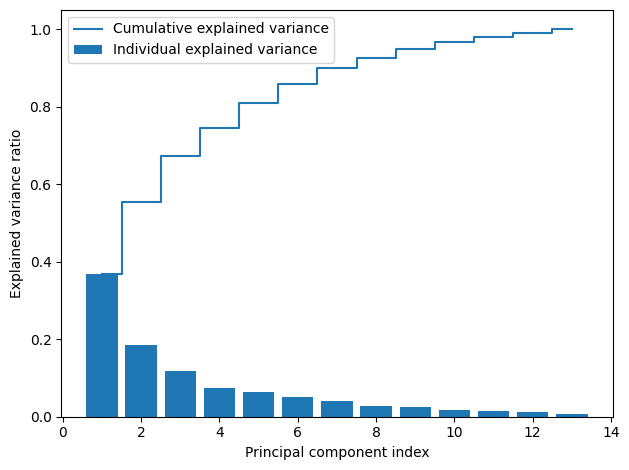

In [4]:
# plot variance explained ratios of eigenvalues (fraction of eigenvalue and total sum of eigenvalues)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, align='center', label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
# 1. sort eigenpairs is descending order of eigen values
# 2. construction projection matrix from selected eigenvectors
# 3. use projection matrix to transform data onto lower-dimensional subspace

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [6]:
# select top two eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [7]:
# project matrix to new subspace
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [11]:
# transform entire training dataset using 2 PCA
X_train_pca = X_train_std.dot(w)
X_train_pca

array([[ 2.38299011,  0.45458499],
       [-1.96578183,  1.65376939],
       [-2.53907598,  1.02909066],
       [-1.43010776,  0.6024011 ],
       [ 3.14147227,  0.66214979],
       [ 0.50253552, -2.08907131],
       [ 0.04867722, -2.27536044],
       [ 2.47888989, -0.08603318],
       [ 2.01900259, -1.3538719 ],
       [ 0.75156583, -2.55367947],
       [ 0.72268915, -1.18404391],
       [-3.00366211,  0.94626934],
       [ 2.57518878, -1.0697549 ],
       [ 3.73151104,  1.01968876],
       [-1.12276518,  0.13877   ],
       [ 2.85996853,  2.28819559],
       [-0.74717125, -3.21746061],
       [-1.58427878,  0.16048055],
       [ 3.38887101,  2.11550689],
       [ 3.15405473,  0.54233966],
       [-1.28036506, -1.72926871],
       [-1.71438911,  0.71745249],
       [-1.55040291, -1.7580591 ],
       [ 1.10984489, -1.20480693],
       [-0.69108418, -1.71385374],
       [-2.086036  , -1.68453671],
       [ 2.90393456,  1.95258805],
       [-2.07635784,  1.47183304],
       [-1.74756185,

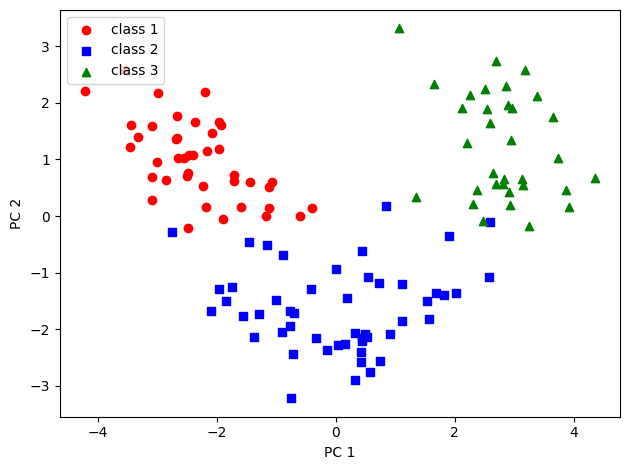

In [10]:
# visualize training dataset (now 124x2) on new subspace
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=f'class {l}', marker=m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()